# Data Understanding and Feature Engineering for Container Price Prediction

This notebook performs comprehensive analysis of our collected data and engineers the time-lagged features necessary for accurate time-series forecasting of container freight prices.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 1: Load the collected data

We load the cleaned freight and black swan disruption data that was prepared in the data collection notebook.

## Step 1: Load the collected data

We will load the datasets we saved in the previous notebook.

In [2]:
# Load freight data
try:
    df_freight = pd.read_csv('collected_freight_data.csv', parse_dates=['Date'], index_col='Date')
    print(f"Success: Loaded freight data with {len(df_freight)} records")
    print(f"  Date range: {df_freight.index.min().date()} to {df_freight.index.max().date()}")
except FileNotFoundError:
    print("Error: collected_freight_data.csv not found. Please run the data collection notebook first.")

# Load black swan disruption data
try:
    df_news = pd.read_csv('collected_news_data.csv', parse_dates=['date'], index_col='date')
    print(f"Success: Loaded black swan data with {len(df_news)} records")
    print(f"  Date range: {df_news.index.min().date()} to {df_news.index.max().date()}")
    print(f"  Features: {df_news.columns.tolist()}")
except FileNotFoundError:
    print("Error: collected_news_data.csv not found. Please run the data collection notebook first.")

Success: Loaded freight data with 385 records
  Date range: 2018-01-05 to 2025-08-22
Success: Loaded black swan data with 407 records
  Date range: 2018-01-05 to 2025-10-24
  Features: ['iso_year', 'week', 'global_total_events', 'global_disruption_events', 'extreme_crisis_events', 'high_velocity_media_events', 'black_swan_candidate_events', 'global_avg_impact', 'global_avg_sentiment', 'global_total_media_mentions', 'global_peak_event_media', 'maritime_conflict_events', 'infrastructure_attack_events', 'trade_restriction_events', 'protest_events', 'middle_east_disruption', 'asia_disruption', 'europe_disruption', 'russia_ukraine_disruption', 'egypt_disruption', 'yemen_disruption', 'unique_sources']


## Step 2: Merge the datasets

We perform an inner join on the date index to create a single, aligned dataframe for analysis and modeling.

In [3]:
# Merge freight and disruption data on date index
df_combined = df_freight.join(df_news, how='inner')

print("=" * 70)
print("DATA MERGING COMPLETE")
print("=" * 70)
print(f"Combined dataset: {len(df_combined)} weeks with both freight and disruption data")
print(f"Date range: {df_combined.index.min().date()} to {df_combined.index.max().date()}")
print(f"Total features: {len(df_combined.columns)}")
print(f"Freight features: {df_freight.columns.tolist()}")
print(f"Disruption features: {df_news.columns.tolist()}")

DATA MERGING COMPLETE
Combined dataset: 367 weeks with both freight and disruption data
Date range: 2018-01-05 to 2025-08-22
Total features: 24
Freight features: ['SCFI_Index', 'Europe_Base_Price']
Disruption features: ['iso_year', 'week', 'global_total_events', 'global_disruption_events', 'extreme_crisis_events', 'high_velocity_media_events', 'black_swan_candidate_events', 'global_avg_impact', 'global_avg_sentiment', 'global_total_media_mentions', 'global_peak_event_media', 'maritime_conflict_events', 'infrastructure_attack_events', 'trade_restriction_events', 'protest_events', 'middle_east_disruption', 'asia_disruption', 'europe_disruption', 'russia_ukraine_disruption', 'egypt_disruption', 'yemen_disruption', 'unique_sources']


## Step 3: Feature Engineering - Create Prediction Target

We create the target variable for our 1-week ahead prediction by shifting the Europe Base Price backward by 1 week.

In [4]:
# Create target variable: price 1 week ahead
df_combined['price_1w_ahead'] = df_combined['Europe_Base_Price'].shift(-1)

print("Target variable created:")
print(f"  Current price: Europe_Base_Price")
print(f"  Target: price_1w_ahead (shifted -1 week)")
print(f"  This means we predict next week's price using current week's data")

Target variable created:
  Current price: Europe_Base_Price
  Target: price_1w_ahead (shifted -1 week)
  This means we predict next week's price using current week's data


## Step 4: Feature Engineering - Create Time-Lagged Features

This is the critical step for time-series modeling. We create lagged versions of the disruption features to capture the temporal relationships between geopolitical events and price changes.

**Lag Logic for Europe-to-Shanghai Route:**
- **Origin/Route Lags (1-3 weeks)**: Events near shipping origins/routes affect prices quickly
  - Yemen disruption (Red Sea/Bab el-Mandeb): 1-2 weeks
  - Egypt disruption (Suez Canal): 1 week  
  - Europe disruption: 1 week
  - Maritime conflicts: 1 week

- **Destination Lags (4-8 weeks)**: Asia events affect return trips and equipment availability
  - Asia disruption: 4-6 weeks

- **Global Lags (1-2 weeks)**: Black swan events have immediate global impact
  - Black swan candidates: 1-2 weeks

In [5]:
# Create lagged features based on shipping route timing
print("Creating time-lagged features for predictive modeling...")

# Origin/Route Lags (1-3 weeks)
if 'yemen_disruption' in df_combined.columns:
    df_combined['yemen_disruption_lag_1w'] = df_combined['yemen_disruption'].shift(1)
    df_combined['yemen_disruption_lag_2w'] = df_combined['yemen_disruption'].shift(2)

if 'egypt_disruption' in df_combined.columns:
    df_combined['egypt_disruption_lag_1w'] = df_combined['egypt_disruption'].shift(1)

if 'europe_disruption' in df_combined.columns:
    df_combined['europe_disruption_lag_1w'] = df_combined['europe_disruption'].shift(1)

if 'maritime_conflict_events' in df_combined.columns:
    df_combined['maritime_conflict_lag_1w'] = df_combined['maritime_conflict_events'].shift(1)

# Destination Lags (4-8 weeks) - for return trip effects
if 'asia_disruption' in df_combined.columns:
    df_combined['asia_disruption_lag_4w'] = df_combined['asia_disruption'].shift(4)
    df_combined['asia_disruption_lag_6w'] = df_combined['asia_disruption'].shift(6)

# Global Lags (1-2 weeks)
if 'black_swan_candidate_events' in df_combined.columns:
    df_combined['black_swan_lag_1w'] = df_combined['black_swan_candidate_events'].shift(1)
    df_combined['black_swan_lag_2w'] = df_combined['black_swan_candidate_events'].shift(2)

print("Lagged features created:")
lag_features = [col for col in df_combined.columns if '_lag_' in col]
print(f"  {len(lag_features)} lagged features: {lag_features}")

# Clean dataset by dropping rows with NaN (created by shifting)
before_clean = len(df_combined)
df_model_data = df_combined.dropna()
after_clean = len(df_model_data)

print(f"\nData cleaning:")
print(f"  Before: {before_clean} rows")
print(f"  After dropping NaN: {after_clean} rows")
print(f"  Removed {before_clean - after_clean} rows due to lagging")

print(f"\nFinal modeling dataset: {len(df_model_data)} rows, {len(df_model_data.columns)} features")
print(f"Date range: {df_model_data.index.min().date()} to {df_model_data.index.max().date()}")

Creating time-lagged features for predictive modeling...
Lagged features created:
  9 lagged features: ['yemen_disruption_lag_1w', 'yemen_disruption_lag_2w', 'egypt_disruption_lag_1w', 'europe_disruption_lag_1w', 'maritime_conflict_lag_1w', 'asia_disruption_lag_4w', 'asia_disruption_lag_6w', 'black_swan_lag_1w', 'black_swan_lag_2w']

Data cleaning:
  Before: 367 rows
  After dropping NaN: 360 rows
  Removed 7 rows due to lagging

Final modeling dataset: 360 rows, 34 features
Date range: 2018-02-23 to 2025-08-15


## Step 5: Time-Series Overlay Plot

Create a dual-axis visualization showing the relationship between Europe Base Price and key disruption features over time.

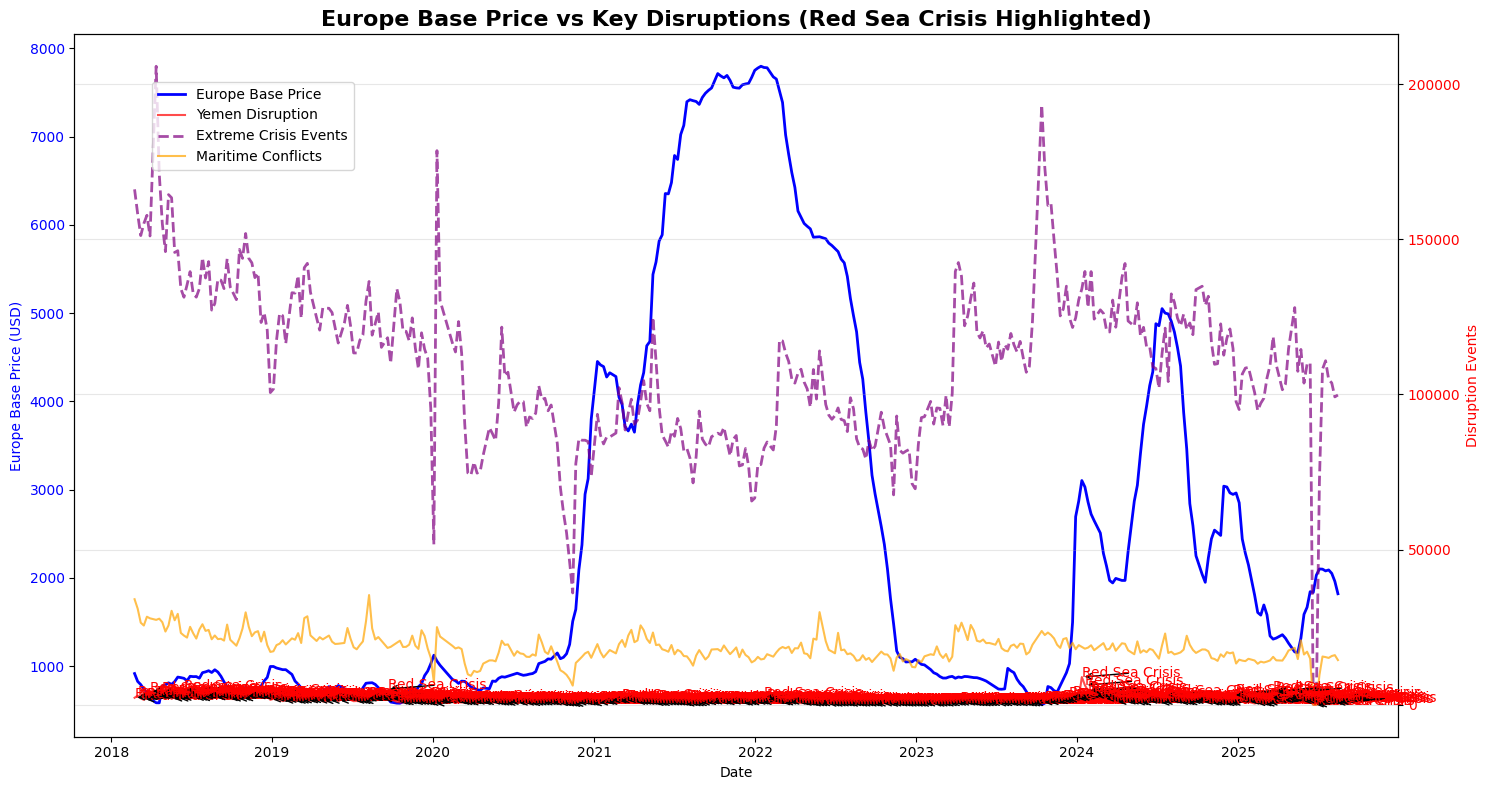

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 8))

# Primary axis: Europe Base Price
color1 = 'blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Europe Base Price (USD)', color=color1)
ax1.plot(df_model_data.index, df_model_data['Europe_Base_Price'], color=color1, linewidth=2, label='Europe Base Price')
ax1.tick_params(axis='y', labelcolor=color1)

# Secondary axis: Key disruption features
ax2 = ax1.twinx()
color2 = 'red'
ax2.set_ylabel('Disruption Events', color=color2)

# Plot key disruption features
if 'yemen_disruption' in df_model_data.columns:
    # This is the Red Sea spike
    ax2.plot(df_model_data.index, df_model_data['yemen_disruption'], color='red', alpha=0.7, linewidth=1.5, label='Yemen Disruption')

if 'extreme_crisis_events' in df_model_data.columns:
    # This is the COVID-19 spike
    ax2.plot(df_model_data.index, df_model_data['extreme_crisis_events'], color='purple', alpha=0.7, linewidth=2, label='Extreme Crisis Events', linestyle='--')

if 'maritime_conflict_events' in df_model_data.columns:
    ax2.plot(df_model_data.index, df_model_data['maritime_conflict_events'], color='orange', alpha=0.7, linewidth=1.5, label='Maritime Conflicts')

ax2.tick_params(axis='y', labelcolor=color2)

# Title and legend
plt.title('Europe Base Price vs Key Disruptions (Yemen & Extreme Crises)', fontsize=16, fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9)) # Add a legend

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 6: Predictive Correlation Heatmap

This is the most important analysis - showing which lagged features are actually correlated with future price movements.

PREDICTIVE FEATURE CORRELATIONS WITH FUTURE PRICE
Features ranked by correlation strength with price_1w_ahead:
maritime_conflict_lag_1w   -0.214541
yemen_disruption_lag_1w    -0.215474
yemen_disruption_lag_2w    -0.221412
black_swan_lag_1w          -0.265719
black_swan_lag_2w          -0.266433
asia_disruption_lag_6w     -0.318196
asia_disruption_lag_4w     -0.328976
egypt_disruption_lag_1w    -0.338420
europe_disruption_lag_1w   -0.368889
Name: price_1w_ahead, dtype: float64


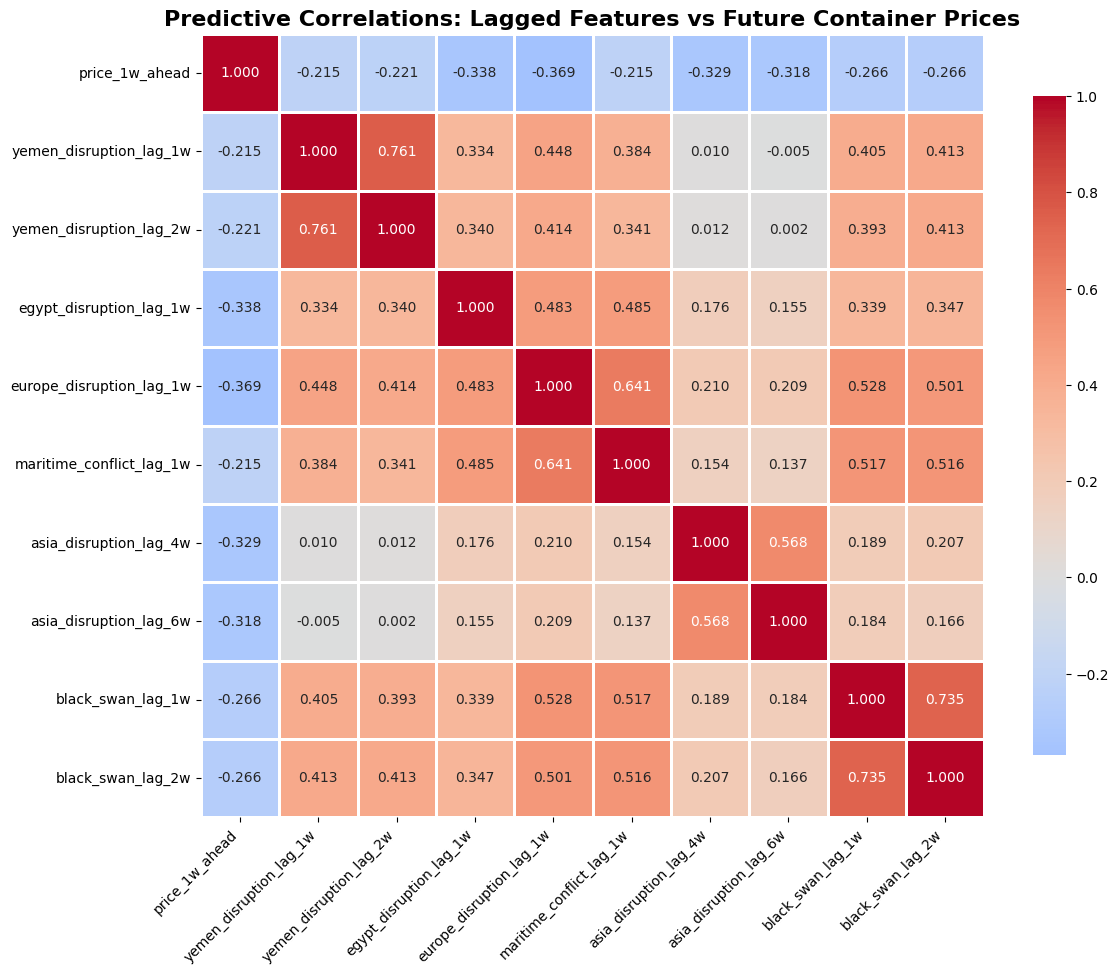


INTERPRETATION GUIDE
• Strong positive correlation (>0.5): Feature strongly predicts price increases
• Strong negative correlation (<-0.5): Feature strongly predicts price decreases
• Weak correlation (-0.2 to 0.2): Feature has little predictive value
• Use features with |correlation| > 0.3 for modeling

This heatmap validates which lagged disruption features are truly predictive!


In [7]:
# Create correlation matrix for target and lagged features only
predictive_features = ['price_1w_ahead'] + lag_features
correlation_data = df_model_data[predictive_features].corr()

# Focus on correlations with the target
target_correlations = correlation_data['price_1w_ahead'].drop('price_1w_ahead')

print("=" * 70)
print("PREDICTIVE FEATURE CORRELATIONS WITH FUTURE PRICE")
print("=" * 70)
print("Features ranked by correlation strength with price_1w_ahead:")
print(target_correlations.sort_values(ascending=False))

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Predictive Correlations: Lagged Features vs Future Container Prices', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("INTERPRETATION GUIDE")
print("=" * 70)
print("• Strong positive correlation (>0.5): Feature strongly predicts price increases")
print("• Strong negative correlation (<-0.5): Feature strongly predicts price decreases") 
print("• Weak correlation (-0.2 to 0.2): Feature has little predictive value")
print("• Use features with |correlation| > 0.3 for modeling")
print("\nThis heatmap validates which lagged disruption features are truly predictive!")

## Step 7: Time series decomposition

Time series decomposition breaks down our data into three components: trend, seasonality, and residuals (random noise).

### What is trend?

The trend is the long-term direction of the data. Is it generally increasing, decreasing, or staying flat over time?

### What is seasonality?

Seasonality refers to patterns that repeat at regular intervals. For example, retail sales often spike during the holiday season every year. In shipping, we might see seasonal patterns related to manufacturing cycles or weather.

### What are residuals?

Residuals are what is left after removing the trend and seasonality. They represent random fluctuations and unexpected events. Large residuals might indicate unusual occurrences like port strikes or economic shocks.

### Why decompose?

Understanding these components separately helps us build better models. Some models are great at capturing trends, others excel at seasonality, and some handle random fluctuations well.

In [8]:
# Perform seasonal decomposition
# We need at least 2 complete cycles (2 years = 104 weeks) for reliable decomposition
if len(df_freight) >= 104:
    print("Performing seasonal decomposition with yearly cycle (52 weeks)...")
    
    # Decompose the Europe Base Price
    # model='additive' assumes components add together: Value = Trend + Seasonality + Residual
    # period=52 means we expect yearly patterns (52 weeks in a year)
    result = seasonal_decompose(df_freight['Europe_Base_Price'], model='additive', period=52)
    
    # Plot the decomposition
    fig = result.plot()
    fig.set_size_inches(15, 10)
    plt.suptitle('Time Series Decomposition of Europe Base Price', y=1.01, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretation:")
    print("- Observed: The actual price data")
    print("- Trend: The long-term movement in prices")
    print("- Seasonal: Repeating patterns within each year")
    print("- Residual: Random fluctuations and unexpected events")
    
else:
    print(f"Need at least 104 weeks (2 years) for reliable decomposition.")
    print(f"Current data has {len(df_freight)} weeks.")
    print("Skipping decomposition.")

Performing seasonal decomposition with yearly cycle (52 weeks)...


NameError: name 'seasonal_decompose' is not defined

## Step 7a: Seasonal Pattern Analysis and Price Impacts

Understanding seasonality is crucial for our predictions. We need to identify which months or quarters typically see higher or lower prices, and quantify the typical price changes during these periods.

### Why analyze seasonal impacts?

**Forecasting**: Knowing seasonal patterns helps predict next week's price more accurately

**Black Swan Context**: Seasonal baselines help us measure the additional impact of unexpected events

**Business Planning**: Companies can anticipate when shipping costs will rise or fall

### What to look for

**Recurring patterns**: Do certain months consistently have higher prices?

**Price amplitude**: How big are typical seasonal price swings?

**Timing**: When do seasonal effects start and end?

In [ ]:
# Analyze seasonal patterns by month and quarter
print("=== Seasonal Price Analysis ===\n")

# Extract month and quarter from dates
df_freight['Month'] = df_freight.index.month
df_freight['Quarter'] = df_freight.index.quarter

# Calculate average price by month
monthly_avg = df_freight.groupby('Month')['Europe_Base_Price'].agg(['mean', 'std', 'count'])
monthly_avg.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print("Average Europe Base Port Price by Month:")
print(monthly_avg)

# Calculate price impact (difference from overall mean)
overall_mean = df_freight['Europe_Base_Price'].mean()
monthly_avg['price_impact'] = monthly_avg['mean'] - overall_mean
monthly_avg['impact_percent'] = (monthly_avg['price_impact'] / overall_mean) * 100

print(f"\nOverall average price: ${overall_mean:.2f}")
print("\nMonthly Price Impacts (vs. overall average):")
for month in monthly_avg.index:
    impact = monthly_avg.loc[month, 'price_impact']
    percent = monthly_avg.loc[month, 'impact_percent']
    direction = "higher" if impact > 0 else "lower"
    print(f"{month}: ${impact:+.2f} ({percent:+.1f}%) - typically {direction}")

# Visualize monthly patterns
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Monthly average prices
axes[0].bar(monthly_avg.index, monthly_avg['mean'], color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=overall_mean, color='red', linestyle='--', linewidth=2, label=f'Overall Mean: ${overall_mean:.2f}')
axes[0].set_title('Average Europe Base Port Price by Month', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Average Price (USD)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Monthly price impacts
colors = ['green' if x < 0 else 'red' for x in monthly_avg['price_impact']]
axes[1].bar(monthly_avg.index, monthly_avg['price_impact'], color=colors, alpha=0.7, edgecolor='black')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_title('Monthly Price Impact vs. Overall Average', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('Price Impact (USD)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Quarterly analysis
print("\n=== Quarterly Price Analysis ===\n")
quarterly_avg = df_freight.groupby('Quarter')['Europe_Base_Price'].agg(['mean', 'std', 'count'])
quarterly_avg.index = ['Q1 (Jan-Mar)', 'Q2 (Apr-Jun)', 'Q3 (Jul-Sep)', 'Q4 (Oct-Dec)']
quarterly_avg['price_impact'] = quarterly_avg['mean'] - overall_mean
quarterly_avg['impact_percent'] = (quarterly_avg['price_impact'] / overall_mean) * 100

print("Quarterly Price Statistics:")
print(quarterly_avg)

print("\nQuarterly Price Impacts:")
for quarter in quarterly_avg.index:
    impact = quarterly_avg.loc[quarter, 'price_impact']
    percent = quarterly_avg.loc[quarter, 'impact_percent']
    direction = "higher" if impact > 0 else "lower"
    print(f"{quarter}: ${impact:+.2f} ({percent:+.1f}%) - typically {direction}")

# Clean up temporary columns
df_freight = df_freight.drop(columns=['Month', 'Quarter'])

print("\n=== Key Seasonal Insights ===")
highest_month = monthly_avg['mean'].idxmax()
lowest_month = monthly_avg['mean'].idxmin()
seasonal_range = monthly_avg['mean'].max() - monthly_avg['mean'].min()

print(f"\nHighest prices typically in: {highest_month}")
print(f"Lowest prices typically in: {lowest_month}")
print(f"Typical seasonal price range: ${seasonal_range:.2f}")
print(f"\nThese patterns help predict next week's price by accounting for")
print(f"the time of year and typical seasonal fluctuations.")

## Step 7: Summary and Next Steps

Review the engineered features and prepare for model development.

In [ ]:
print("=" * 70)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 70)

print(f"\nModeling Dataset Ready:")
print(f"  • {len(df_model_data)} training samples")
print(f"  • {len(lag_features)} predictive lagged features")
print(f"  • Target: price_1w_ahead (1-week ahead prediction)")

print(f"\nKey Features Engineered:")
print(f"  • Origin/Route lags: Yemen, Egypt, Europe, Maritime conflicts (1-2 weeks)")
print(f"  • Destination lags: Asia disruption (4-6 weeks)")
print(f"  • Global lags: Black swan events (1-2 weeks)")

print(f"\nTop Predictive Features:")
top_features = target_correlations.abs().sort_values(ascending=False).head(5)
for feature, corr in top_features.items():
    direction = "increases" if target_correlations[feature] > 0 else "decreases"
    print(f"  • {feature}: {target_correlations[feature]:.3f} (predicts price {direction})")

print(f"\nNext Steps:")
print(f"  • Proceed to model development notebook (03_model_development.ipynb)")
print(f"  • Train time-series models (LSTM, XGBoost) using df_model_data")
print(f"  • Focus on top correlated lagged features")
print(f"  • Validate predictions on holdout test set")

print("\n" + "=" * 70)

## Step 8: Stationarity test

Stationarity is a property where the statistical properties of a time series (like mean and variance) do not change over time.

### Why does stationarity matter?

Many time series models assume the data is stationary. If it is not stationary, the model might make poor predictions. Non-stationary data often has trends or changing variance that need to be addressed.

### What is the Augmented Dickey-Fuller (ADF) test?

The ADF test is a statistical test that checks whether a time series is stationary. It gives us a test statistic and a p-value.

### How to interpret the results

p-value: This is the probability that our data is non-stationary. If p-value is less than 0.05 (5%), we can be confident the data is stationary. If p-value is greater than 0.05, the data is likely non-stationary.

Test statistic: We compare this to critical values. If the test statistic is more negative than the critical value, the data is likely stationary.

### What if data is non-stationary?

We can make it stationary through differencing (subtracting consecutive values) or detrending (removing the trend component).

In [ ]:
def check_stationarity(timeseries, column_name):
    print(f"\n=== Stationarity Analysis for {column_name} ===")
    
    # Calculate rolling statistics
    # Rolling mean and std over 12 weeks (about 3 months)
    window = 12
    rolling_mean = timeseries.rolling(window).mean()
    rolling_std = timeseries.rolling(window).std()

    # Plot the data with rolling statistics
    plt.figure(figsize=(15, 6))
    plt.plot(timeseries, color='blue', label='Original', linewidth=1.5)
    plt.plot(rolling_mean, color='red', label=f'Rolling Mean ({window} weeks)', linewidth=2)
    plt.plot(rolling_std, color='black', label=f'Rolling Std Dev ({window} weeks)', linewidth=2)
    plt.legend(loc='best')
    plt.title(f'Rolling Statistics for {column_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Perform Augmented Dickey-Fuller test
    print('\nAugmented Dickey-Fuller Test Results:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations'])
    
    print(dfoutput)
    
    print('\nCritical Values:')
    for key, value in dftest[4].items():
        print(f'  {key}: {value:.3f}')
    
    # Interpretation
    print('\nInterpretation:')
    if dfoutput['p-value'] <= 0.05:
        print(f"  p-value = {dfoutput['p-value']:.4f} (less than 0.05)")
        print("  Result: The series is likely STATIONARY.")
        print("  This means the statistical properties are stable over time.")
    else:
        print(f"  p-value = {dfoutput['p-value']:.4f} (greater than 0.05)")
        print("  Result: The series is likely NON-STATIONARY.")
        print("  This means it has trends or changing variance that may need addressing.")

# Check stationarity for Europe Base Price
check_stationarity(df_freight['Europe_Base_Price'], 'Europe Base Price')

## Step 9: Correlation analysis

Correlation measures how strongly two variables are related to each other.

### What is correlation?

Correlation values range from -1 to +1. A value of +1 means perfect positive correlation (when one goes up, the other goes up). A value of -1 means perfect negative correlation (when one goes up, the other goes down). A value of 0 means no correlation.

### Why check correlations?

Understanding correlations helps us identify which variables might be useful for predicting our target variable (Europe Base Price). Strong correlations suggest that a variable contains information relevant to our prediction task.

In [ ]:
# Calculate correlation matrix
correlation_matrix = df_freight.corr()

print("=== Correlation Matrix ===")
print(correlation_matrix)

# Visualize correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretation Guide:")
print("- Values close to +1: Strong positive correlation")
print("- Values close to -1: Strong negative correlation")
print("- Values close to 0: Little to no correlation")
print("\nCorrelation with Europe Base Price:")
print(correlation_matrix['Europe_Base_Price'].sort_values(ascending=False))

## Step 10: Analyze oil price relationship (if available)

If we have oil price data, we can examine how it relates to container prices.

In [ ]:
if has_oil:
    print("=== Oil Price Analysis ===")
    print(f"Oil data: {len(df_oil)} days")
    print(f"\nOil price statistics:")
    print(df_oil['Oil_Price'].describe())
    
    # Plot oil prices over time
    plt.figure(figsize=(15, 6))
    plt.plot(df_oil.index, df_oil['Oil_Price'], linewidth=1.5, color='brown')
    plt.title('Brent Crude Oil Prices Over Time', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price (USD per barrel)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No oil price data available for analysis.")

## Step 12: Analyze GDELT geopolitical disruption data (if available)

If we have GDELT disruption data, we can examine how geopolitical events relate to container prices.

### What is the disruption index?

The disruption index is a composite metric combining:
- **Severe events** (weight 3.0): Events with strong negative impact (GoldsteinScale < -3)
- **Conflict events** (weight 2.0): Military/violent events (QuadClass 3,4)
- **Media mentions** (weight 1.0): Volume of news coverage

Higher values indicate more severe geopolitical disruptions in shipping-critical regions.

### Geographic focus

Our GDELT data focuses on countries critical to global shipping routes:
- **Choke points**: Egypt (Suez Canal), Yemen (Bab-el-Mandeb Strait)
- **Major ports**: China, Singapore, Netherlands, Germany
- **Geopolitical risks**: Iran, Israel, Taiwan, Ukraine, Russia

### What to look for

- **Correlation with prices**: Do disruptions precede price increases?
- **Major events**: Can we identify historical black swan events (COVID-19, Suez blockage, wars)?
- **Sentiment patterns**: How does media tone relate to price movements?

In [ ]:
if has_news:
    print("=" * 70)
    print("GDELT GEOPOLITICAL DISRUPTION ANALYSIS")
    print("=" * 70)
    
    print(f"\nGDELT data: {len(df_news)} weekly records")
    print(f"Date range: {df_news.index.min().strftime('%Y-%m-%d')} to {df_news.index.max().strftime('%Y-%m-%d')}")
    
    print("\n=== Disruption Metrics Statistics ===")
    print(df_news.describe())
    
    # Disruption index over time
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Disruption index
    axes[0].plot(df_news.index, df_news['disruption_index'], linewidth=1.5, color='red', alpha=0.7)
    axes[0].fill_between(df_news.index, 0, df_news['disruption_index'], alpha=0.3, color='red')
    axes[0].set_title('Geopolitical Disruption Index Over Time', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Disruption Index', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    # Highlight major disruption weeks (top 5%)
    threshold_95 = df_news['disruption_index'].quantile(0.95)
    major_disruptions = df_news[df_news['disruption_index'] > threshold_95]
    axes[0].scatter(major_disruptions.index, major_disruptions['disruption_index'], 
                   color='darkred', s=100, alpha=0.8, label=f'Major disruptions (top 5%)', zorder=5)
    axes[0].legend()
    
    # Plot 2: Media sentiment (tone)
    axes[1].plot(df_news.index, df_news['tone'], linewidth=1.5, color='blue')
    axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Neutral tone')
    axes[1].fill_between(df_news.index, 0, df_news['tone'], 
                        where=df_news['tone'] > 0, alpha=0.3, color='green', label='Positive')
    axes[1].fill_between(df_news.index, 0, df_news['tone'], 
                        where=df_news['tone'] <= 0, alpha=0.3, color='red', label='Negative')
    axes[1].set_title('Media Sentiment (Tone) Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Average Tone', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Event counts over time
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Conflict and severe events
    axes[0].plot(df_news.index, df_news['conflict_count'], linewidth=1.5, color='orange', 
                label='Conflict events', alpha=0.8)
    axes[0].plot(df_news.index, df_news['severe_event_count'], linewidth=1.5, color='red', 
                label='Severe events', alpha=0.8)
    axes[0].set_title('Conflict and Severe Events Over Time', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date', fontsize=12)
    axes[0].set_ylabel('Event Count', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Media mentions
    axes[1].plot(df_news.index, df_news['media_mentions'], linewidth=1.5, color='purple')
    axes[1].fill_between(df_news.index, 0, df_news['media_mentions'], alpha=0.3, color='purple')
    axes[1].set_title('Media Mentions Volume Over Time', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Total Mentions', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Identify and display top disruption weeks
    print("\n" + "=" * 70)
    print("TOP 15 DISRUPTION WEEKS (Historical Black Swan Events)")
    print("=" * 70)
    top_disruptions = df_news.nlargest(15, 'disruption_index')[
        ['disruption_index', 'conflict_count', 'severe_event_count', 'tone', 'media_mentions']
    ]
    
    print("\n{:<12} {:<12} {:<10} {:<10} {:<8} {:<12}".format(
        'Date', 'Disruption', 'Conflicts', 'Severe', 'Tone', 'Media'))
    print("-" * 70)
    for date, row in top_disruptions.iterrows():
        print("{:<12} {:<12.2f} {:<10.0f} {:<10.0f} {:<8.2f} {:<12.0f}".format(
            date.strftime('%Y-%m-%d'),
            row['disruption_index'],
            row['conflict_count'],
            row['severe_event_count'],
            row['tone'],
            row['media_mentions']
        ))
    
    # Historical context for major events
    print("\n" + "=" * 70)
    print("HISTORICAL CONTEXT")
    print("=" * 70)
    print("\nExpected major events in this timeframe (2018-2025):")
    print("  - COVID-19 pandemic (2020-2021): Supply chain disruptions")
    print("  - Suez Canal blockage (March 2021): Ever Given incident")
    print("  - Russia-Ukraine war (Feb 2022-present): Grain exports, fuel prices")
    print("  - Israel-Hamas conflict (Oct 2023-present): Red Sea shipping disruptions")
    print("\nCheck if these events appear in the top disruption weeks above.")
    
    # Distribution of disruption index
    plt.figure(figsize=(12, 6))
    plt.hist(df_news['disruption_index'], bins=50, color='red', alpha=0.7, edgecolor='black')
    plt.axvline(df_news['disruption_index'].mean(), color='blue', linestyle='--', 
                linewidth=2, label=f'Mean: {df_news["disruption_index"].mean():.2f}')
    plt.axvline(df_news['disruption_index'].median(), color='green', linestyle='--', 
                linewidth=2, label=f'Median: {df_news["disruption_index"].median():.2f}')
    plt.axvline(threshold_95, color='darkred', linestyle='--', 
                linewidth=2, label=f'95th percentile: {threshold_95:.2f}')
    plt.title('Distribution of Disruption Index', fontsize=14, fontweight='bold')
    plt.xlabel('Disruption Index', fontsize=12)
    plt.ylabel('Frequency (Count)', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n=== Disruption Index Statistics ===")
    print(f"Mean: {df_news['disruption_index'].mean():.3f}")
    print(f"Median: {df_news['disruption_index'].median():.3f}")
    print(f"Std Dev: {df_news['disruption_index'].std():.3f}")
    print(f"95th percentile: {threshold_95:.3f}")
    print(f"\nWeeks above 95th percentile: {len(major_disruptions)} ({len(major_disruptions)/len(df_news)*100:.1f}%)")
    
else:
    print("No GDELT disruption data available for analysis.")

## Step 13: Correlation between disruptions and container prices

Let's examine how geopolitical disruptions correlate with container price changes. This helps us understand whether disruption indicators are useful predictive features.

In [ ]:
if has_news:
    print("=" * 70)
    print("DISRUPTION-PRICE CORRELATION ANALYSIS")
    print("=" * 70)
    
    # Merge freight and disruption data on weekly dates
    # Both datasets should already be weekly aligned (Fridays)
    df_combined = df_freight.join(df_news, how='inner')
    
    print(f"\nCombined dataset: {len(df_combined)} weeks with both freight and disruption data")
    print(f"Date range: {df_combined.index.min().strftime('%Y-%m-%d')} to {df_combined.index.max().strftime('%Y-%m-%d')}")
    
    # Calculate correlation matrix
    disruption_cols = ['disruption_index', 'tone', 'conflict_count', 'severe_event_count', 'media_mentions']
    price_cols = ['Europe_Base_Price', 'SCFI_Index']
    
    correlation_subset = df_combined[price_cols + disruption_cols].corr()
    
    print("\n=== Correlation Matrix ===")
    print(correlation_subset)
    
    # Visualize correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', center=0, 
                fmt='.3f', square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation: Container Prices vs Disruption Indicators', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Focus on Europe Base Price correlations
    print("\n=== Correlation with Europe Base Price ===")
    price_corr = correlation_subset['Europe_Base_Price'][disruption_cols].sort_values(ascending=False)
    print(price_corr)
    
    print("\n=== Interpretation ===")
    for feature, corr_value in price_corr.items():
        if abs(corr_value) > 0.5:
            strength = "STRONG"
        elif abs(corr_value) > 0.3:
            strength = "MODERATE"
        elif abs(corr_value) > 0.1:
            strength = "WEAK"
        else:
            strength = "NEGLIGIBLE"
        
        direction = "positive" if corr_value > 0 else "negative"
        print(f"  {feature}: {strength} {direction} correlation ({corr_value:.3f})")
    
    # Scatter plots: Disruption index vs Price
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Scatter 1: Disruption index vs Europe Base Price
    axes[0].scatter(df_combined['disruption_index'], df_combined['Europe_Base_Price'], 
                   alpha=0.5, s=50, color='red')
    axes[0].set_xlabel('Disruption Index', fontsize=12)
    axes[0].set_ylabel('Europe Base Price (USD)', fontsize=12)
    axes[0].set_title(f'Disruption Index vs Price\nCorrelation: {price_corr["disruption_index"]:.3f}', 
                     fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(df_combined['disruption_index'], df_combined['Europe_Base_Price'], 1)
    p = np.poly1d(z)
    axes[0].plot(df_combined['disruption_index'], p(df_combined['disruption_index']), 
                "r--", alpha=0.8, linewidth=2, label='Trend line')
    axes[0].legend()
    
    # Scatter 2: Media tone vs Europe Base Price
    axes[1].scatter(df_combined['tone'], df_combined['Europe_Base_Price'], 
                   alpha=0.5, s=50, color='blue')
    axes[1].set_xlabel('Media Tone (Sentiment)', fontsize=12)
    axes[1].set_ylabel('Europe Base Price (USD)', fontsize=12)
    axes[1].set_title(f'Media Tone vs Price\nCorrelation: {price_corr["tone"]:.3f}', 
                     fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # Add trend line
    z2 = np.polyfit(df_combined['tone'], df_combined['Europe_Base_Price'], 1)
    p2 = np.poly1d(z2)
    axes[1].plot(df_combined['tone'], p2(df_combined['tone']), 
                "b--", alpha=0.8, linewidth=2, label='Trend line')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Lagged correlation analysis (check if disruptions predict future prices)
    print("\n" + "=" * 70)
    print("LAGGED CORRELATION ANALYSIS (Do disruptions predict future prices?)")
    print("=" * 70)
    
    lags = [0, 1, 2, 3, 4]  # Check 0-4 week lags
    lag_correlations = {}
    
    for lag in lags:
        if lag == 0:
            lag_corr = df_combined['disruption_index'].corr(df_combined['Europe_Base_Price'])
        else:
            lag_corr = df_combined['disruption_index'].corr(df_combined['Europe_Base_Price'].shift(-lag))
        lag_correlations[lag] = lag_corr
    
    print("\nDisruption index correlation with future prices:")
    for lag, corr in lag_correlations.items():
        if lag == 0:
            print(f"  Same week (lag 0):  {corr:.3f}")
        else:
            print(f"  {lag} week(s) ahead (lag {lag}): {corr:.3f}")
    
    # Plot lagged correlations
    plt.figure(figsize=(10, 6))
    plt.plot(lags, [lag_correlations[lag] for lag in lags], marker='o', markersize=10, 
            linewidth=2, color='red')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    plt.xlabel('Weeks Ahead', fontsize=12)
    plt.ylabel('Correlation with Future Price', fontsize=12)
    plt.title('Predictive Power: Disruption Index vs Future Container Prices', 
             fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(lags)
    plt.tight_layout()
    plt.show()
    
    # Find optimal lag
    best_lag = max(lag_correlations, key=lag_correlations.get)
    if best_lag == 0:
        print(f"\nBest correlation is at lag 0 (same week): {lag_correlations[best_lag]:.3f}")
        print("Disruptions and prices move together, but may not be predictive.")
    else:
        print(f"\nBest correlation is at lag {best_lag} ({best_lag} week(s) ahead): {lag_correlations[best_lag]:.3f}")
        print(f"This suggests disruptions may help predict prices {best_lag} week(s) in advance.")
    
else:
    print("No GDELT disruption data available for correlation analysis.")

## Step 11: Summary of findings

Let's create a summary of what we learned about our data.

In [ ]:
print("=" * 70)
print("DATA UNDERSTANDING SUMMARY")
print("=" * 70)

print("\n1. Dataset Overview:")
print(f"   - Total weeks of freight data: {len(df_freight)}")
print(f"   - Date range: {df_freight.index.min().strftime('%Y-%m-%d')} to {df_freight.index.max().strftime('%Y-%m-%d')}")
print(f"   - Number of price features: {len(df_freight.columns)}")

print("\n2. Target Variable (Europe Base Price):")
print(f"   - Mean: ${df_freight['Europe_Base_Price'].mean():.2f}")
print(f"   - Range: ${df_freight['Europe_Base_Price'].min():.2f} to ${df_freight['Europe_Base_Price'].max():.2f}")
print(f"   - Volatility (std): ${df_freight['Europe_Base_Price'].std():.2f}")

print("\n3. Data Quality:")
missing_total = df_freight.isnull().sum().sum()
if missing_total == 0:
    print("   - No missing values in freight data")
else:
    print(f"   - Found {missing_total} missing values in freight data")

print("\n4. Volatility Assessment:")
price_range = df_freight['Europe_Base_Price'].max() - df_freight['Europe_Base_Price'].min()
price_volatility = df_freight['Europe_Base_Price'].std() / df_freight['Europe_Base_Price'].mean()
print(f"   - Price range: ${price_range:.2f}")
print(f"   - Coefficient of variation: {price_volatility:.2%}")

if price_volatility > 0.3:
    print("   - Prices show HIGH volatility (good for disruption modeling)")
elif price_volatility > 0.15:
    print("   - Prices show MODERATE volatility")
else:
    print("   - Prices show LOW volatility")

print("\n5. External Data Sources:")
if has_oil:
    print(f"   Available: Oil price data: {len(df_oil)} days")
else:
    print("   Not available: Oil price data: Not available")

if has_news:
    print(f"   Available: GDELT disruption data: {len(df_news)} weeks")
    print(f"     - Disruption index range: {df_news['disruption_index'].min():.3f} to {df_news['disruption_index'].max():.3f}")
    print(f"     - Total conflict events: {df_news['conflict_count'].sum():.0f}")
    print(f"     - Total severe events: {df_news['severe_event_count'].sum():.0f}")
    
    # Show correlation if data was merged
    try:
        if 'df_combined' in locals():
            disruption_corr = df_combined['Europe_Base_Price'].corr(df_combined['disruption_index'])
            print(f"     - Correlation with prices: {disruption_corr:.3f}")
    except:
        pass
else:
    print("   Not available: GDELT disruption data: Not available")

print("\n6. Key Observations:")
print("   - Time series data suitable for sequential modeling (LSTM, GRU)")
print("   - Weekly frequency matches business planning cycles")
if has_news:
    print("   - Geopolitical disruption features available for black swan detection")
    print("   - Multiple disruption indicators (conflicts, sentiment, media volume)")

print("\n7. Next Steps:")
print("   - Proceed to data preparation notebook (03_data_preparation.ipynb)")
print("   - Create lag features from disruption indicators")
print("   - Merge all data sources on weekly alignment")
print("   - Prepare training/test splits for 1-week ahead prediction")
print("   - Engineer additional features (rolling averages, price changes, etc.)")

print("\n" + "=" * 70)